In [66]:
# Import the required modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# ##### Data Manipulation 

In [67]:
# Read the train.csv file from the Resources folder into a Pandas DataFrame
GeneticDisorder_df = pd.read_csv(
    Path("..") / "Resources" / "train.csv"
)

# Review the DataFrame
display(GeneticDisorder_df.head())
display(GeneticDisorder_df.tail())

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
22078,PID0x5598,4.0,Yes,Yes,Yes,No,5.258298,Lynn,NaN,Alhassane,...,Multiple,6.584811,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
22079,PID0x19cb,8.0,No,Yes,No,Yes,4.974220,Matthew,Farley,Dartanion,...,Multiple,7.041556,inconclusive,1.0,1.0,1.0,1.0,0.0,Multifactorial genetic inheritance disorders,Diabetes
22080,PID0x3c4f,8.0,Yes,No,Yes,No,5.186470,John,NaN,Cavani,...,Singular,7.715464,normal,0.0,0.0,0.0,1.0,NaN,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy
22081,PID0x13a,7.0,Yes,No,Yes,Yes,4.858543,Sharon,NaN,Bomer,...,Multiple,8.437670,abnormal,1.0,1.0,1.0,0.0,0.0,NaN,Leigh syndrome
22082,PID0x9332,11.0,Yes,No,No,No,4.738067,Andrew,Mose,Eban,...,Singular,11.188371,normal,1.0,0.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes


In [68]:
# Get column names and data
GeneticDisorder_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Id                                        22083 non-null  object 
 1   Patient Age                                       20656 non-null  float64
 2   Genes in mother's side                            22083 non-null  object 
 3   Inherited from father                             21777 non-null  object 
 4   Maternal gene                                     19273 non-null  object 
 5   Paternal gene                                     22083 non-null  object 
 6   Blood cell count (mcL)                            22083 non-null  float64
 7   Patient First Name                                22083 non-null  object 
 8   Family Name                                       12392 non-null  object 
 9   Father's name    

In [69]:
# Replace '-' with 'Not applicable' in the entire DataFrame
GeneticDisorder_df = GeneticDisorder_df.copy()
GeneticDisorder_df.replace('-', 'Not applicable', inplace=True)


In [70]:
# Replace 'Not applicable' with 'No' in the entire DataFrame
# GeneticDisorder_df = GeneticDisorder_df.copy()
# GeneticDisorder_df.replace('Not applicable', 'No', inplace=True)

In [71]:
# Replace 'Genetic Disorder' column blanks based on 'Disorder subclass' column values

# Create a mapping dictionary for each condition
condition_mapping = {
    'Cystic Fibrosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    "Alzheimer's": 'Multifactorial genetic inheritance disorders',
    "Leber's hereditary optic neuropathy": 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders'
}

# Replace blanks in 'Genetic Disorder' column based on conditions
GeneticDisorder_df['Genetic Disorder'] = GeneticDisorder_df.apply(lambda row: condition_mapping.get(row['Disorder Subclass'], row['Genetic Disorder']), axis=1)

In [73]:
# Drop unnecessary columns from the training dataset
columns_to_remove = ['Patient Id', 'Patient First Name', 'Family Name', 'Father\'s name', 'Mother\'s age', 'Father\'s age', 'Institute Name', 'Location of Institute','Test 1','Test 2','Test 3','Test 4','Test 5','Symptom 1','Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5', 'Parental consent', 'Autopsy shows birth defect (if applicable)', 'Disorder Subclass']
columns_to_remove_train = [col for col in columns_to_remove if col in GeneticDisorder_df.columns]
GeneticDisorder_cleaned_df = GeneticDisorder_df.drop(columns=columns_to_remove_train)

In [74]:
# Count the number of NaN values in each column
nan_counts = GeneticDisorder_cleaned_df.isna().sum()

# Display the results
print("Number of NaN values in each column:")
print(nan_counts)

Number of NaN values in each column:
Patient Age                                         1427
Genes in mother's side                                 0
Inherited from father                                306
Maternal gene                                       2810
Paternal gene                                          0
Blood cell count (mcL)                                 0
Status                                                 0
Respiratory Rate (breaths/min)                      2149
Heart Rate (rates/min                               2113
Follow-up                                           2166
Gender                                              2173
Birth asphyxia                                      2139
Place of birth                                      2124
Folic acid details (peri-conceptional)              2117
H/O serious maternal illness                        2152
H/O radiation exposure (x-ray)                      2153
H/O substance abuse                                

In [75]:
# Drop rows with missing values
GeneticDisorder_dropped_df = GeneticDisorder_cleaned_df.dropna()

In [76]:
# Confirm no NaN values are reflected
nan_counts_after_drop = GeneticDisorder_dropped_df.isna().sum()
print("\nNumber of NaN values in each column after dropping rows:")
print(nan_counts_after_drop)


Number of NaN values in each column after dropping rows:
Patient Age                                         0
Genes in mother's side                              0
Inherited from father                               0
Maternal gene                                       0
Paternal gene                                       0
Blood cell count (mcL)                              0
Status                                              0
Respiratory Rate (breaths/min)                      0
Heart Rate (rates/min                               0
Follow-up                                           0
Gender                                              0
Birth asphyxia                                      0
Place of birth                                      0
Folic acid details (peri-conceptional)              0
H/O serious maternal illness                        0
H/O radiation exposure (x-ray)                      0
H/O substance abuse                                 0
Assisted conception IVF/

In [77]:
# Confirm that are no duplicate rows
duplicate_count = GeneticDisorder_dropped_df.duplicated().sum()

print("Count of duplicate rows:", duplicate_count)

# X_train_no_duplicates = GeneticDisorder_dropped_df.drop_duplicates()

Count of duplicate rows: 0


In [78]:
# Display the cleaned DataFrame
display(GeneticDisorder_dropped_df.head())
display(GeneticDisorder_dropped_df.tail())

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,...,H/O serious maternal illness,H/O radiation exposure (x-ray),H/O substance abuse,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Genetic Disorder
8,11.0,No,No,Yes,No,5.209058,Alive,Tachypnea,Tachycardia,Low,...,Yes,No,No,No,Yes,0.0,Multiple,6.669552,slightly abnormal,Mitochondrial genetic inheritance disorders
9,4.0,No,Yes,Yes,Yes,4.752272,Alive,Tachypnea,Tachycardia,Low,...,No,No,No,Yes,Yes,1.0,Multiple,6.397702,abnormal,Multifactorial genetic inheritance disorders
12,1.0,Yes,Yes,No,No,4.612265,Deceased,Normal (30-60),Tachycardia,High,...,No,Yes,Not applicable,Yes,Yes,0.0,Singular,7.995115,slightly abnormal,Mitochondrial genetic inheritance disorders
14,6.0,Yes,No,Yes,No,4.620420,Alive,Tachypnea,Tachycardia,High,...,Yes,Yes,Not applicable,No,No,3.0,Multiple,3.000000,slightly abnormal,Mitochondrial genetic inheritance disorders
18,10.0,Yes,Yes,Yes,No,4.751452,Deceased,Normal (30-60),Tachycardia,Low,...,No,Yes,No,Yes,Yes,3.0,Singular,9.382407,abnormal,Mitochondrial genetic inheritance disorders


,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,...,H/O serious maternal illness,H/O radiation exposure (x-ray),H/O substance abuse,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Genetic Disorder
22068,4.0,Yes,No,No,No,5.077554,Deceased,Normal (30-60),Normal,Low,...,Yes,No,Not applicable,No,No,1.0,Singular,9.566549,inconclusive,Multifactorial genetic inheritance disorders
22076,0.0,Yes,No,Yes,No,4.931758,Alive,Normal (30-60),Tachycardia,Low,...,No,Not applicable,No,Yes,Yes,1.0,Singular,11.649052,abnormal,Mitochondrial genetic inheritance disorders
22079,8.0,No,Yes,No,Yes,4.974220,Alive,Normal (30-60),Normal,High,...,Yes,No,Not applicable,Yes,No,2.0,Multiple,7.041556,inconclusive,Multifactorial genetic inheritance disorders
22081,7.0,Yes,No,Yes,Yes,4.858543,Alive,Tachypnea,Tachycardia,High,...,Yes,Not applicable,Yes,Yes,No,1.0,Multiple,8.437670,abnormal,Mitochondrial genetic inheritance disorders
22082,11.0,Yes,No,No,No,4.738067,Deceased,Normal (30-60),Normal,High,...,Yes,Not applicable,No,Yes,Yes,4.0,Singular,11.188371,normal,Multifactorial genetic inheritance disorders


In [79]:
# Export cleaned CSV data
# GeneticDisorder_dropped_df.to_csv('Resources/GeneticDisorder_cleaned_AllFeatures.csv', index=False)

In [80]:
# Identify categorical columns
categorical_columns = GeneticDisorder_dropped_df.select_dtypes(include=['object']).columns

# Perform one-hot encoding on categorical columns
GeneticDisorder_encoded_df = pd.get_dummies(GeneticDisorder_dropped_df, columns=categorical_columns, drop_first=True)
GeneticDisorder_encoded_df


,Patient Age,Blood cell count (mcL),No. of previous abortion,White Blood cell count (thousand per microliter),Genes in mother's side_Yes,Inherited from father_Yes,Maternal gene_Yes,Paternal gene_Yes,Status_Deceased,Respiratory Rate (breaths/min)_Tachypnea,...,H/O substance abuse_Not applicable,H/O substance abuse_Yes,Assisted conception IVF/ART_Yes,History of anomalies in previous pregnancies_Yes,Birth defects_Singular,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal,Genetic Disorder_Multifactorial genetic inheritance disorders,Genetic Disorder_Single-gene inheritance diseases
8,11.0,5.209058,0.0,6.669552,False,False,True,False,False,True,...,False,False,False,True,False,False,False,True,False,False
9,4.0,4.752272,1.0,6.397702,False,True,True,True,False,True,...,False,False,True,True,False,False,False,False,True,False
12,1.0,4.612265,0.0,7.995115,True,True,False,False,True,False,...,True,False,True,True,True,False,False,True,False,False
14,6.0,4.620420,3.0,3.000000,True,False,True,False,False,True,...,True,False,False,False,False,False,False,True,False,False
18,10.0,4.751452,3.0,9.382407,True,True,True,False,True,False,...,False,False,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22068,4.0,5.077554,1.0,9.566549,True,False,False,False,True,False,...,True,False,False,False,True,True,False,False,True,False
22076,0.0,4.931758,1.0,11.649052,True,False,True,False,False,False,...,False,False,True,True,True,False,False,False,False,False
22079,8.0,4.974220,2.0,7.041556,False,True,False,True,False,False,...,True,False,True,False,False,True,False,False,True,False
22081,7.0,4.858543,1.0,8.437670,True,False,True,True,False,True,...,False,True,True,False,False,False,False,False,False,False


In [81]:
# Obtain the 'Genetic Disorder' names in the columns
print(GeneticDisorder_encoded_df.columns)

Index(['Patient Age', 'Blood cell count (mcL)', 'No. of previous abortion',
       'White Blood cell count (thousand per microliter)',
       'Genes in mother's side_Yes', 'Inherited from father_Yes',
       'Maternal gene_Yes', 'Paternal gene_Yes', 'Status_Deceased',
       'Respiratory Rate (breaths/min)_Tachypnea',
       'Heart Rate (rates/min_Tachycardia', 'Follow-up_Low', 'Gender_Female',
       'Gender_Male', 'Birth asphyxia_No record',
       'Birth asphyxia_Not available', 'Birth asphyxia_Yes',
       'Place of birth_Institute',
       'Folic acid details (peri-conceptional)_Yes',
       'H/O serious maternal illness_Yes',
       'H/O radiation exposure (x-ray)_Not applicable',
       'H/O radiation exposure (x-ray)_Yes',
       'H/O substance abuse_Not applicable', 'H/O substance abuse_Yes',
       'Assisted conception IVF/ART_Yes',
       'History of anomalies in previous pregnancies_Yes',
       'Birth defects_Singular', 'Blood test result_inconclusive',
       'Blood test 

In [82]:
# Create a binary target column indicating the presence (1) or absence (0) of a genetic disorder
GeneticDisorder_encoded_df['Multifactorial or Single-gene inheritance GeneticDisorder_Present'] = ( 
    GeneticDisorder_encoded_df['Genetic Disorder_Multifactorial genetic inheritance disorders']   # Diabetes, Cancer, or Alzheimer's Present
    | GeneticDisorder_encoded_df['Genetic Disorder_Single-gene inheritance diseases'] #Cystic fibrosis, Hemochromatosis, or Tay-Sachs Present
).astype(int)

# Drop the original columns used for creating the binary target column
GeneticDisorder_encoded_df.drop(['Genetic Disorder_Multifactorial genetic inheritance disorders', 'Genetic Disorder_Single-gene inheritance diseases'], axis=1, inplace=True)

# 'Multifactorial or Single-gene inheritance GeneticDisorder_Present' is now the binary target column


In [83]:
# Using all columns as features for training
X = GeneticDisorder_encoded_df.drop(['Multifactorial or Single-gene inheritance GeneticDisorder_Present'], axis=1)  # Exclude the target column
y = GeneticDisorder_encoded_df['Multifactorial or Single-gene inheritance GeneticDisorder_Present']


In [84]:
# View the updated dataset
GeneticDisorder_encoded_df

,Patient Age,Blood cell count (mcL),No. of previous abortion,White Blood cell count (thousand per microliter),Genes in mother's side_Yes,Inherited from father_Yes,Maternal gene_Yes,Paternal gene_Yes,Status_Deceased,Respiratory Rate (breaths/min)_Tachypnea,...,H/O radiation exposure (x-ray)_Yes,H/O substance abuse_Not applicable,H/O substance abuse_Yes,Assisted conception IVF/ART_Yes,History of anomalies in previous pregnancies_Yes,Birth defects_Singular,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal,Multifactorial or Single-gene inheritance GeneticDisorder_Present
8,11.0,5.209058,0.0,6.669552,False,False,True,False,False,True,...,False,False,False,False,True,False,False,False,True,0
9,4.0,4.752272,1.0,6.397702,False,True,True,True,False,True,...,False,False,False,True,True,False,False,False,False,1
12,1.0,4.612265,0.0,7.995115,True,True,False,False,True,False,...,True,True,False,True,True,True,False,False,True,0
14,6.0,4.620420,3.0,3.000000,True,False,True,False,False,True,...,True,True,False,False,False,False,False,False,True,0
18,10.0,4.751452,3.0,9.382407,True,True,True,False,True,False,...,True,False,False,True,True,True,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22068,4.0,5.077554,1.0,9.566549,True,False,False,False,True,False,...,False,True,False,False,False,True,True,False,False,1
22076,0.0,4.931758,1.0,11.649052,True,False,True,False,False,False,...,False,False,False,True,True,True,False,False,False,0
22079,8.0,4.974220,2.0,7.041556,False,True,False,True,False,False,...,False,True,False,True,False,False,True,False,False,1
22081,7.0,4.858543,1.0,8.437670,True,False,True,True,False,True,...,False,False,True,True,False,False,False,False,False,0


In [85]:
# Export GeneticDisorder_encoded_df to CSV file
# GeneticDisorder_encoded_df.to_csv('Resources/GeneticDisorder_encoded_AllFeatures.csv', index=False)

# ### Logistic Regression Model

In [86]:
# Split into testing and training sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [87]:
# Handle imbalanced classes using SMOTE
smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# SMOTE is an oversampling technique that works by generating synthetic samples for the minority class. It helps to balance the class distribution in a dataset, which can be useful when one class has significantly fewer samples than the other.

In [88]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [89]:
# Declare a logistic regression model.
# Apply a random_state of 9 to the model
logistic_regression_model = LogisticRegression(random_state=9, max_iter=1000)

# Fit and save the logistic regression model using the data
lr_model = logistic_regression_model.fit(X_train_scaled, y_resampled)

In [90]:
#Generate training predictions
GDtraining_predictions = lr_model.predict(X_train_scaled)

#Generate testing predictions
GDtesting_predictions = logistic_regression_model.predict(X_test_scaled)

In [91]:
# Cross-Validation for Logistic Regression
cv_scores_lr = cross_val_score(logistic_regression_model, X_train_scaled, y_resampled, cv=5)
print("Logistic Regression Cross-Validation Scores:", cv_scores_lr)
print("Mean Cross-Validation Score (LR):", cv_scores_lr.mean())

# the mean cross-validation score provides a summary measure of the model's average performance

Logistic Regression Cross-Validation Scores: [0.50848896 0.51782683 0.50594228 0.51952462 0.50594228]
Mean Cross-Validation Score (LR): 0.5115449915110357


In [92]:
# Create and save the confusion matrix for the training data
GDtraining_matrix = confusion_matrix(y_resampled, GDtraining_predictions)

# Print the confusion matrix for the training data
print("Confusion Matrix for Logistic Regression model (Training Data):")
print(GDtraining_matrix)

Confusion Matrix for Logistic Regression model (Training Data):
[[1596 1349]
 [1387 1558]]


In [93]:
# Create and save the confusion matrix for the testing data
GDtesting_matrix = confusion_matrix(y_test, GDtesting_predictions)

# Print the confusion matrix for the testing data
print("Confusion Matrix for Logistic Regression model (Testing Data):")
print(GDtesting_matrix)

Confusion Matrix for Logistic Regression model (Testing Data):
[[516 481]
 [477 453]]


In [94]:
# Create and save the training classification report
GDtraining_report = classification_report(y_resampled, GDtraining_predictions)

# Print the training classification report
print("Training Classification Report for Logistic Regression model:")
print(GDtraining_report)

Training Classification Report for Logistic Regression model:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      2945
           1       0.54      0.53      0.53      2945

    accuracy                           0.54      5890
   macro avg       0.54      0.54      0.54      5890
weighted avg       0.54      0.54      0.54      5890



In [95]:
# Create and save the testing classification report
GDtesting_report = classification_report(y_test, GDtesting_predictions)

# Print the testing classification report
print("Testing Classification Report for Logistic Regression model:")
print(GDtesting_report)

Testing Classification Report for Logistic Regression model:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       997
           1       0.49      0.49      0.49       930

    accuracy                           0.50      1927
   macro avg       0.50      0.50      0.50      1927
weighted avg       0.50      0.50      0.50      1927



In [96]:
# Print the balanced_accuracy score of the model
print(f"The balanced_accuracy score of the model: {balanced_accuracy_score(y_test, GDtesting_predictions)}")

The balanced_accuracy score of the model: 0.5023247160837351


Using Logistics Regression Model Predict Outcomes Using Genetic Disorder

In [97]:
# Predict outcomes for test data set using the existing logistic regression model
predictions_df = pd.DataFrame({"Prediction": GDtesting_predictions, "Actual": y_test})

print(predictions_df)

       Prediction  Actual
18862           0       0
7976            0       0
17901           1       1
426             0       0
19191           1       0
...           ...     ...
21371           0       0
8321            0       0
5926            0       0
19668           0       0
16831           1       1

[1927 rows x 2 columns]


# ### Visual Representation of Logistic Regression Model

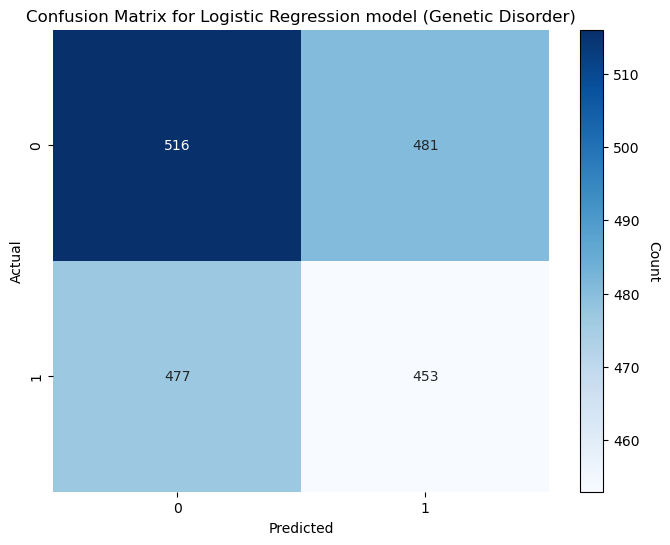

In [98]:
# Confusion Matrix Heatmap for Logistic Regression model
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(GDtesting_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Logistic Regression model (Genetic Disorder)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add legend
cbar = heatmap.figure.colorbar(heatmap.collections[0])
cbar.set_label('Count', rotation=270, labelpad=15)

plt.show()

# The confusion matrix heatmap allows users to visually assess how well the Logistic Regression model \
# is performing in predicting the "Genetic Disorder" by comparing the predicted and actual classes. The goal is \
# to have higher counts along the diagonal (from the top left to the bottom right), indicating correct predictions, and \
# lower counts in off-diagonal cells, indicating misclassifications. The color intensity provides a quick visual summary \
# of the distribution of predictions.

# ### Feature Importance in Logistics Regression

In [99]:
# Get feature names and their coefficients
all_feature_names = GeneticDisorder_encoded_df.drop(['Multifactorial or Single-gene inheritance GeneticDisorder_Present'], axis=1).columns
feature_coefficients_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': lr_model.coef_[0]})
feature_coefficients_df['Absolute Coefficient'] = feature_coefficients_df['Coefficient'].abs()
feature_coefficients_df = feature_coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display top features and their coefficients
print("\nTop Features and Coefficients:")
print(feature_coefficients_df)

# Coefficients indicate the strength and direction (positive or negative) of the relationship between each feature and the predicted outcome. \
# A negative coefficient suggests an inverse relationship between the feature and the predicted outcome. As "Patient Age" and "Blood cell count (mcL)" \
# have negative coefficients, an increase in these values is associated with a decrease in the predicted outcome (lower likelihood of a Genetic Disorder).
# Magnitude (Absolute Coefficient) of the coefficient indicates the strength of the relationship. Larger absolute values indicate a stronger influence on the predicted outcome.



Top Features and Coefficients:
                                             Feature  Coefficient  \
8                                    Status_Deceased     0.063685   
21                H/O radiation exposure (x-ray)_Yes     0.062729   
4                         Genes in mother's side_Yes     0.057425   
29               Blood test result_slightly abnormal     0.055601   
7                                  Paternal gene_Yes     0.055386   
6                                  Maternal gene_Yes     0.038350   
28                          Blood test result_normal     0.037841   
25  History of anomalies in previous pregnancies_Yes    -0.036002   
20     H/O radiation exposure (x-ray)_Not applicable    -0.033708   
0                                        Patient Age     0.028640   
23                           H/O substance abuse_Yes     0.027266   
9           Respiratory Rate (breaths/min)_Tachypnea     0.025667   
15                      Birth asphyxia_Not available     0.025116   
16

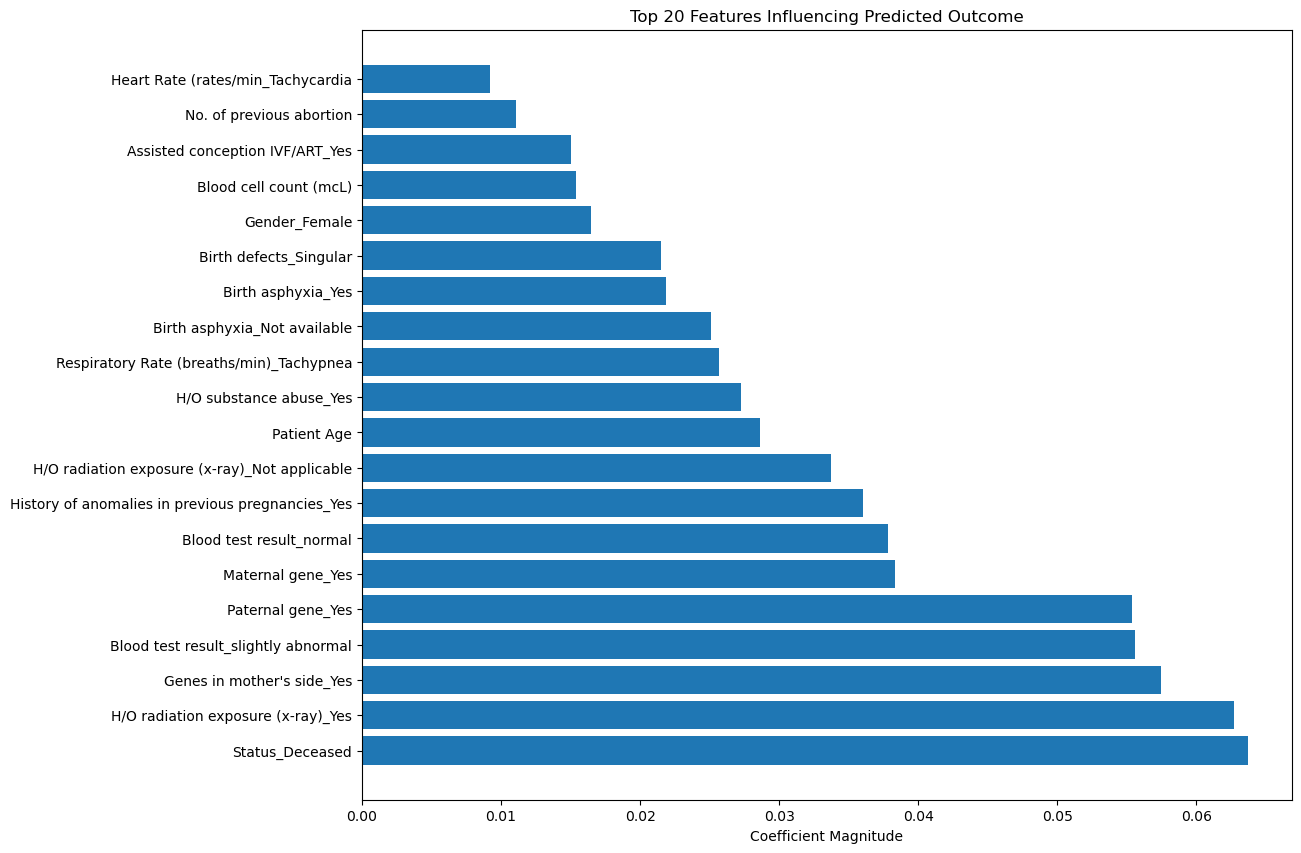

In [100]:
# Plot top 20 features and their importance
plt.figure(figsize=(12, 10))
plt.barh(feature_coefficients_df['Feature'][:20], feature_coefficients_df['Absolute Coefficient'][:20])
plt.xlabel('Coefficient Magnitude')
plt.title('Top 20 Features Influencing Predicted Outcome')
plt.show()

# This graph helps users identify and prioritize the most influential features for the logistic regression model. \
# "Coefficient Magnitude" is a measure of how much a feature contributes to the model's predictions, considering both \
# the positive and negative impacts. Larger magnitudes indicate features that have a more substantial influence on the predicted outcome.

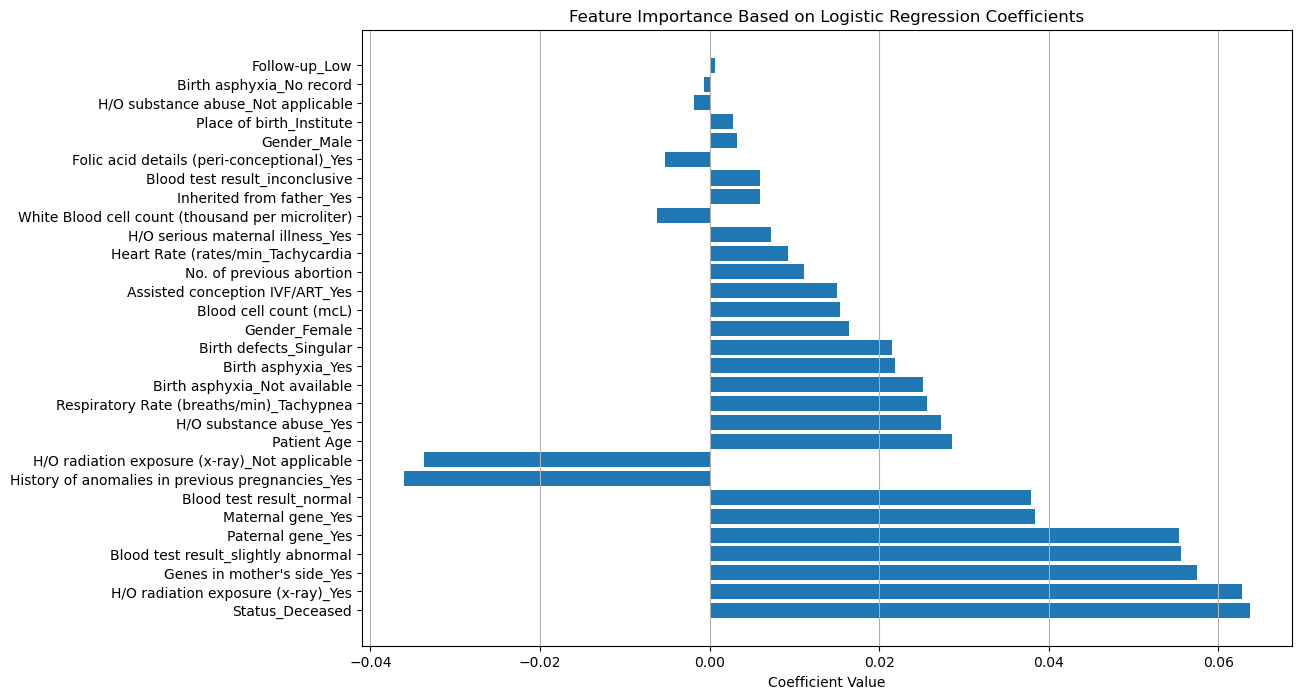

In [101]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_coefficients_df['Feature'], feature_coefficients_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance Based on Logistic Regression Coefficients')
plt.grid(axis='x')
plt.show()

# The graph shows the contribution of each feature to the logistic regression model's predictions \
# The length of each bar represents the magnitude of the coefficient for a specific feature. Larger magnitudes \
# (positive or negative) indicate a stronger impact on the predicted outcome.  The direction of the bar (to the right or left of the centerline) \
# indicates the direction of the impact. If the bar is to the right, it suggests a positive impact on the predicted outcome, while a bar to the left suggests a negative impact. \
# Positive coefficients suggest that an increase in the corresponding feature value makes the prediction more likely to be in class 1 ("Present" in this case), while negative coefficients suggest the opposite.

# ### Random Forest Classifier

In [102]:
# Instantiate a Random Forest classifier
random_forest_model = RandomForestClassifier(random_state=9)

In [103]:
# Fit and save the Random Forest model using the resampled data
random_forest_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=9)

In [104]:
# Generate training predictions using Random Forest
GDtraining_predictions_rf = random_forest_model.predict(X_resampled)

In [105]:
# Generate testing predictions using Random Forest
GDtesting_predictions_rf = random_forest_model.predict(X_test_scaled)

c:\Users\starl\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [106]:
# Cross-Validation for Random Forest
cv_scores_rf = cross_val_score(random_forest_model, X_train_scaled, y_resampled, cv=5)
print("Random Forest Cross-Validation Scores:", cv_scores_rf)
print("Mean Cross-Validation Score (RF):", cv_scores_rf.mean())

Random Forest Cross-Validation Scores: [0.49151104 0.51952462 0.5229202  0.50764007 0.5713073 ]
Mean Cross-Validation Score (RF): 0.5225806451612903


In [107]:
# Create and save the confusion matrix for the training data with Random Forest
GDtraining_matrix_rf = confusion_matrix(y_resampled, GDtraining_predictions_rf)

# Print the confusion matrix for the training data with Random Forest
print("Confusion Matrix for Random Forest model:")
print(GDtraining_matrix_rf)

Confusion Matrix for Random Forest model:
[[2945    0]
 [   0 2945]]


In [108]:
# Create and save the confusion matrix for the testing data with Random Forest
GDtesting_matrix_rf = confusion_matrix(y_test, GDtesting_predictions_rf)

# Print the confusion matrix for the testing data with Random Forest
print("Confusion Matrix for Random Forest model:")
print(GDtesting_matrix_rf)

Confusion Matrix for Random Forest model:
[[521 476]
 [440 490]]


In [109]:
# Create and save the training classification report with Random Forest
GDtraining_report_rf = classification_report(y_resampled, GDtraining_predictions_rf)

# Print the training classification report with Random Forest
print("Classification Report for Random Forest model:")
print(GDtraining_report_rf)

Classification Report for Random Forest model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2945
           1       1.00      1.00      1.00      2945

    accuracy                           1.00      5890
   macro avg       1.00      1.00      1.00      5890
weighted avg       1.00      1.00      1.00      5890



In [110]:
# Create and save the testing classification report with Random Forest
GDtesting_report_rf = classification_report(y_test, GDtesting_predictions_rf)

# Print the testing classification report with Random Forest
print("Classification Report for Random Forest model:")
print(GDtesting_report_rf)

Classification Report for Random Forest model:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       997
           1       0.51      0.53      0.52       930

    accuracy                           0.52      1927
   macro avg       0.52      0.52      0.52      1927
weighted avg       0.53      0.52      0.52      1927



In [111]:
# Print the balanced_accuracy score of the Random Forest model
print(f"The balanced_accuracy score of the Random Forest model: {balanced_accuracy_score(y_test, GDtesting_predictions_rf)}")


The balanced_accuracy score of the Random Forest model: 0.5247247117697178


# ### Feature Importance in Random Forest

In [112]:
# Get feature importances from Random Forest model
rf_feature_importances = random_forest_model.feature_importances_

In [113]:
# Get the names of all features
all_feature_names_rf = GeneticDisorder_encoded_df.columns

In [114]:
# Get the indices of the top 20 features
top_20_indices_rf = rf_feature_importances.argsort()[-20:][::-1]

In [115]:
# Get the names and importance of the top 20 features
top_20_feature_names_rf = all_feature_names_rf[top_20_indices_rf]
top_20_feature_importance_rf = rf_feature_importances[top_20_indices_rf]

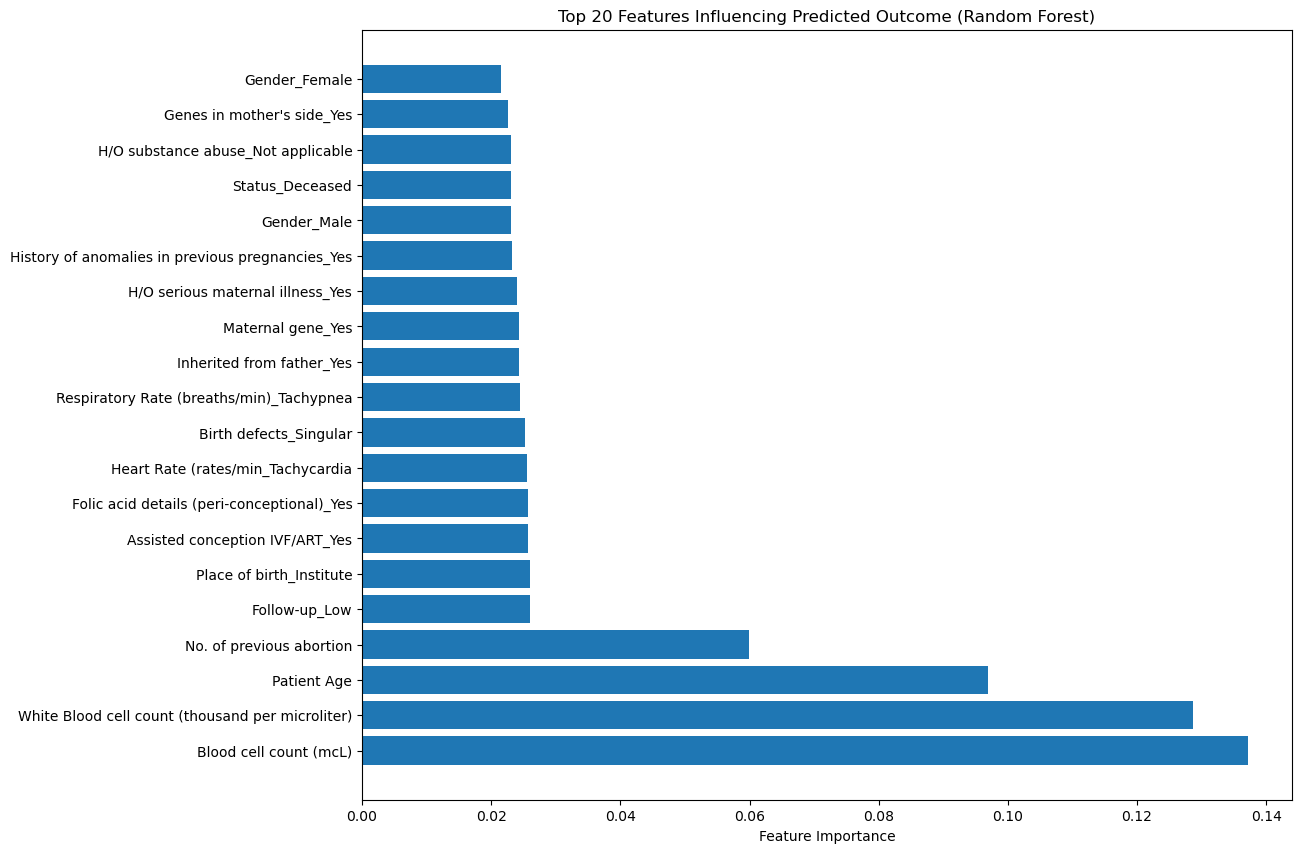

In [116]:
# Plot the top 20 features and their importance from Random Forest
plt.figure(figsize=(12, 10))
plt.barh(top_20_feature_names_rf, top_20_feature_importance_rf)
plt.xlabel('Feature Importance')
plt.title('Top 20 Features Influencing Predicted Outcome (Random Forest)')
plt.show()

# ###### Model Comparison

In [117]:
# Function to display comparison metrics for two models
def compare_models(model1_name, model1_predictions, model2_name, model2_predictions, y_true):
    print(f"Comparison of {model1_name} and {model2_name}:\n")
    
    # Balanced Accuracy
    balanced_acc_model1 = balanced_accuracy_score(y_true, model1_predictions)
    balanced_acc_model2 = balanced_accuracy_score(y_true, model2_predictions)
    print(f"Balanced Accuracy ({model1_name}): {balanced_acc_model1:.4f}")
    print(f"Balanced Accuracy ({model2_name}): {balanced_acc_model2:.4f}\n")
    
    # Classification Report
    print(f"Classification Report ({model1_name}):\n{classification_report(y_true, model1_predictions)}")
    print(f"Classification Report ({model2_name}):\n{classification_report(y_true, model2_predictions)}\n")
    
    # Confusion Matrix
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_true, model1_predictions), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix ({model1_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_true, model2_predictions), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix ({model2_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

Comparison of Logistic Regression and Random Forest:

Balanced Accuracy (Logistic Regression): 0.5023
Balanced Accuracy (Random Forest): 0.5247

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       997
           1       0.49      0.49      0.49       930

    accuracy                           0.50      1927
   macro avg       0.50      0.50      0.50      1927
weighted avg       0.50      0.50      0.50      1927

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       997
           1       0.51      0.53      0.52       930

    accuracy                           0.52      1927
   macro avg       0.52      0.52      0.52      1927
weighted avg       0.53      0.52      0.52      1927




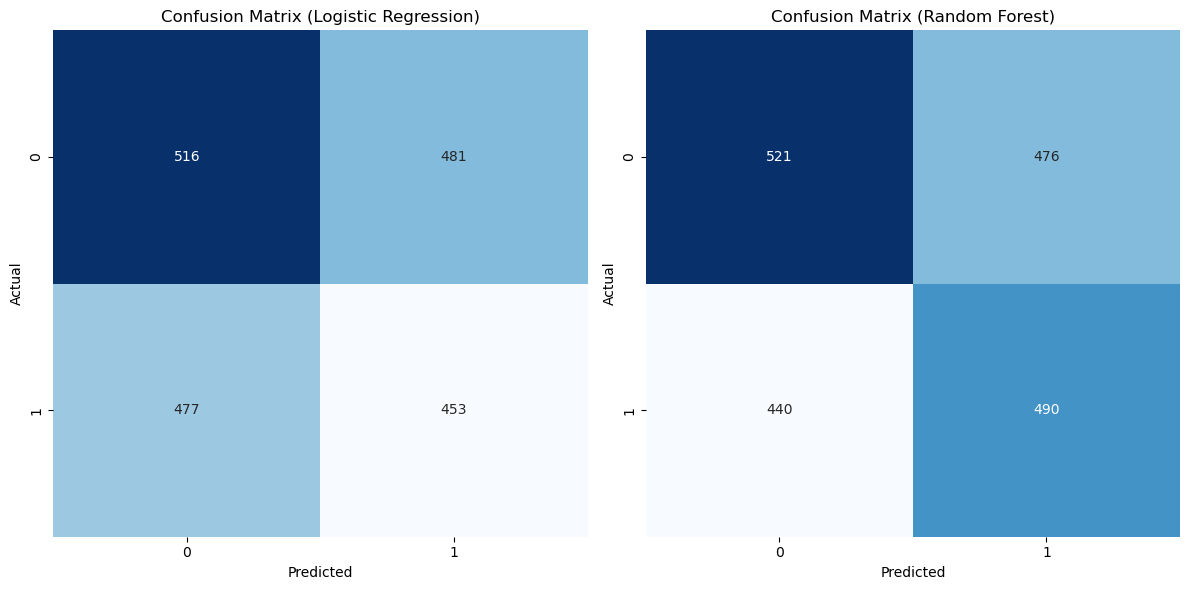

In [118]:
# Compare Logistic Regression and Random Forest
compare_models("Logistic Regression", GDtesting_predictions, "Random Forest", GDtesting_predictions_rf, y_test)

In terms of balanced accuracy, there is a slight difference in favor of Logistic Regression, but the overall performance is comparable. The classification reports provide additional insights into precision, recall, and F1-score for each class. Considering these results, neither model significantly outperforms the other. Further tuning or exploring other algorithms to potentially improve performance would be required.